In [1]:
# Cell 1 - Tell python where to find the modules to import from

import sys
from pathlib import Path

#Path.cwd().parent depends on where you run this code from
#Path(__file__).resolve().parents[1] depends on where this file is located on disk
#
#project_root = .../1099-reconciliation-pipeline if notebook runs from the repo root or from notebooks/
cwd = Path.cwd()
project_root = cwd if (cwd / "src").exists() else cwd.parent # running from notebooks/  folder (cwd = current working directory) - .parent gets us to the folder above
sys.path.append(str(project_root)) #sys.path is a list of folders where python looks for modules
                                    # we add the project root to that list with .append

print("Project root: ", project_root)


Project root:  /Users/manuelreyes/Desktop/dev/1099_reconciliation_pipeline


'--------------------------------  Engine C: Load & Run Analysis  --------------------------------'

In [2]:
# Cell 2 - Imports, Load & Clean inputs (real paths)

from src import load_data
from src.clean_matrix import clean_matrix
from src.clean_relius_demo import clean_relius_demo
from src.clean_relius_roth_basis import clean_relius_roth_basis
from src.roth_taxable_analysis import run_roth_taxable_analysis
from src.roth_taxable_visualization import ( 
    build_roth_kpi_summary,
    plot_roth_kpi_summary,
    build_roth_action_mix,
    plot_roth_action_mix,
    build_roth_correction_reason_summary,
    plot_roth_correction_reason_summary,
    build_roth_correction_reason_trends,
    plot_roth_correction_reason_trends,
    build_taxable_delta_distribution,
    plot_taxable_delta_distribution,
    build_roth_tax_code_crosstab,
    plot_roth_tax_code_crosstab,
)

from src.config import RAW_DATA_DIR, REPORTS_FIGURES_DIR, USE_SAMPLE_DATA_DEFAULT

if USE_SAMPLE_DATA_DEFAULT:
    matrix_path = None
    relius_demo_path = None
    relius_basis_path = None
    sheet_name = 0
else:
    matrix_path = RAW_DATA_DIR / "real_all_matrix_2025.xlsx"
    relius_demo_path = RAW_DATA_DIR / "real_demo_relius_2025.xlsx"
    relius_basis_path = RAW_DATA_DIR / "real_roth_basis_relius_2025.xlsx"
    sheet_name = "Sheet5"

# Load and clean Matrix raw data
matrix_raw = load_data.load_matrix_excel(path=matrix_path)
matrix_clean = clean_matrix(matrix_raw)

# Load and clean Relius demo raw data
relius_demo_raw = load_data.load_relius_demo_excel(path=relius_demo_path)
relius_demo_clean = clean_relius_demo(relius_demo_raw)

# Load and clean Relius Roth basis raw data
relius_basis_raw = load_data.load_relius_roth_basis_excel(path=relius_basis_path, sheet_name=sheet_name)
relius_basis_clean = clean_relius_roth_basis(relius_basis_raw)

# Run Engine C analysis
roth_matches = run_roth_taxable_analysis(
    matrix_clean,
    relius_demo_clean,
    relius_basis_clean,
)

print("Engine C rows:", roth_matches.shape[0])
roth_matches.head(5)


/var/folders/_5/q9dxw26d4rl_63x79z_n9kkm0000gn/T/ipykernel_50749/255807938.py:38: UserWarning: Matrix SSN normalization produced 11 invalid values.
  matrix_clean = clean_matrix(matrix_raw)
/Users/manuelreyes/Desktop/dev/1099_reconciliation_pipeline/src/normalizers.py:144: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.to_datetime(series, errors=errors, format=format, dayfirst=dayfirst).dt.date


Engine C rows: 287


,transaction_id,txn_date,ssn,participant_name,matrix_account,plan_id,tax_code_1,tax_code_2,suggested_tax_code_1,suggested_tax_code_2,...,roth_initial_contribution_year,first_roth_tax_year,start_roth_year,roth_basis_amt,age_at_txn,suggested_taxable_amt,suggested_first_roth_tax_year,correction_reason,action,match_status
0,44745362,2025-11-20,165723517,Rose E. Frankil,07P6LM4G,300005MBD,B,1,<NA>,<NA>,...,2008,2008,2008,1000.0,35.0,<NA>,<NA>,- taxable_within_15pct_of_gross,INVESTIGATE,match_needs_review
1,44568463,2025-11-14,177749131,Selena Merrick,07P6LM4G,300005MBD,H,<NA>,<NA>,<NA>,...,2015,2015,2015,15925.0,32.0,<NA>,<NA>,<NA>,<NA>,match_no_action
2,44568464,2025-11-14,170608226,Andrea Platts,07P6LM4G,300005MBD,H,<NA>,<NA>,<NA>,...,2011,2011,2011,0.0,61.0,<NA>,<NA>,<NA>,<NA>,match_no_action
3,43961174,2025-10-27,163581720,Jeffrey Smith,07P6LM4G,300005MBD,B,7,<NA>,<NA>,...,2025,2018,2018,4350.0,60.0,0.0,2018,- roth_initial_year_mismatch\n- roth_basis_cov...,UPDATE_1099\nINVESTIGATE,match_needs_correction
4,43886241,2025-10-23,208725197,Casey Goebel,07P6LM4G,300005MBD,H,<NA>,<NA>,<NA>,...,2025,2017,2017,5500.0,34.0,<NA>,2017,- roth_initial_year_mismatch,UPDATE_1099,match_needs_correction


'--------------------------------  Metrics & Plots  --------------------------------'

In [3]:
# Cell 3 - Match status KPI summary

kpi_summary = build_roth_kpi_summary(roth_matches)
kpi_summary


,status_group,count,percent
0,no_action,83,0.289199
1,needs_correction,124,0.432056
2,needs_review,34,0.118467
3,excluded_rollover_or_inherited,46,0.160279


Saved: /Users/manuelreyes/Desktop/dev/1099_reconciliation_pipeline/reports/figures/engine_c_match_status_kpi.png


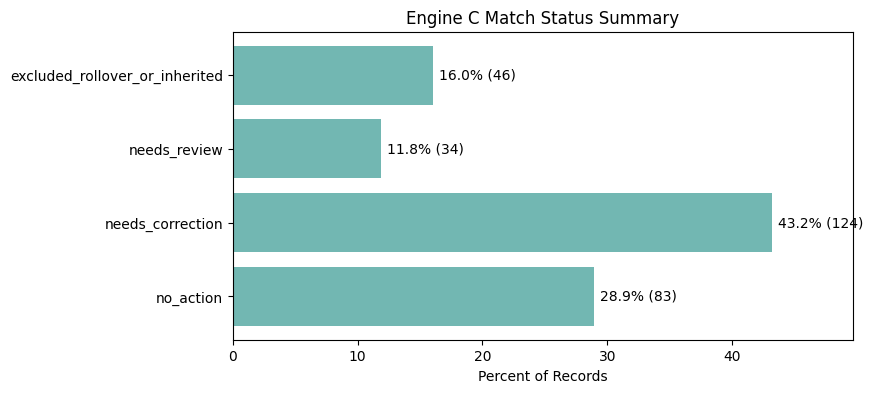

In [4]:
# Cell 4 - Plot match status KPI summary and save

fig1, _ = plot_roth_kpi_summary(kpi_summary)
output_path = REPORTS_FIGURES_DIR / "engine_c_match_status_kpi.png"
fig1.savefig(output_path, dpi=150, bbox_inches="tight")
print("Saved:", output_path)


In [5]:
# Cell 5 - Action mix summary

action_mix = build_roth_action_mix(roth_matches)
action_mix


,action,count,percent
0,UPDATE_1099,124,0.432056
1,INVESTIGATE,116,0.404181


Saved: /Users/manuelreyes/Desktop/dev/1099_reconciliation_pipeline/reports/figures/engine_c_action_mix.png


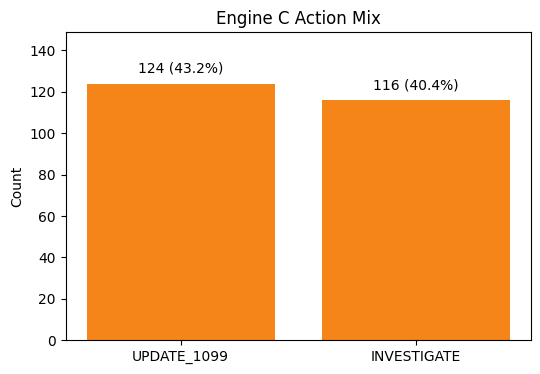

In [6]:
# Cell 6 - Plot action mix and save

fig2, _ = plot_roth_action_mix(action_mix)
output_path = REPORTS_FIGURES_DIR / "engine_c_action_mix.png"
fig2.savefig(output_path, dpi=150, bbox_inches="tight")
print("Saved:", output_path)


In [7]:
# Cell 7 - Correction reason summary

reason_summary = build_roth_correction_reason_summary(roth_matches)
reason_summary


,correction_reason,count,percent
0,taxable_within_15pct_of_gross,82,0.234286
1,roth_initial_year_mismatch,81,0.231429
2,roth_basis_covers_2025_total,44,0.125714
3,missing_first_roth_tax_year,38,0.108571
4,qualified_roth_distribution,32,0.091429
5,roth_age_tax_code_mismatch,23,0.065714
6,roth_rollover_code_fix_B_G_to_H,22,0.062857
7,roth_age_rule_attained_59_5_in_txn_year_expect_B7,11,0.031429
8,roth_age_rule_under_55_in_txn_year_no_term_exp...,6,0.017143
9,roth_rollover_code_fix_G_blank_to_H,3,0.008571


Saved: /Users/manuelreyes/Desktop/dev/1099_reconciliation_pipeline/reports/figures/engine_c_correction_reason_summary.png


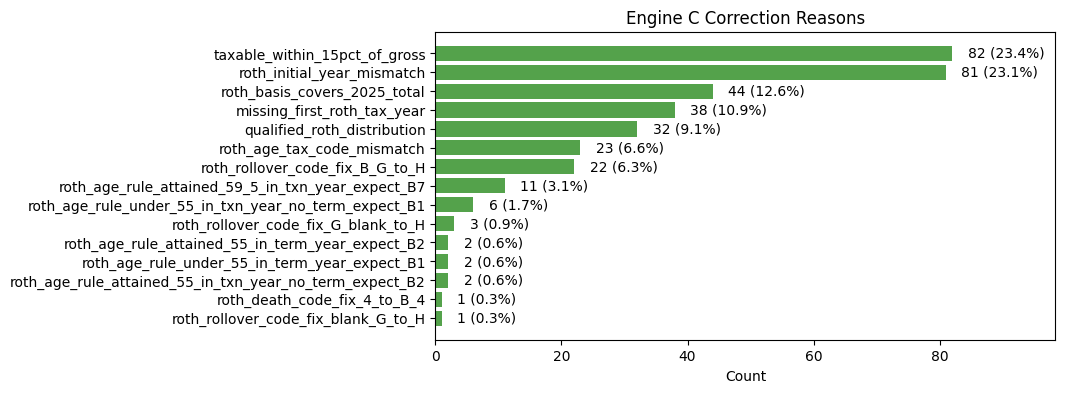

In [8]:
# Cell 8 - Plot correction reason summary and save

fig3, _ = plot_roth_correction_reason_summary(reason_summary)
output_path = REPORTS_FIGURES_DIR / "engine_c_correction_reason_summary.png"
fig3.savefig(output_path, dpi=150, bbox_inches="tight")
print("Saved:", output_path)


In [9]:
# Cell 9 - Taxable delta distribution

taxable_delta = build_taxable_delta_distribution(roth_matches)
taxable_delta.head(10)


,taxable_delta,count
0,-45000.00,1
1,-16294.12,1
2,-14951.44,1
3,-14195.57,1
4,-12558.04,1
5,-12181.19,1
6,-10000.00,1
7,-9990.00,1
8,-9664.14,1
9,-9500.00,1


Saved: /Users/manuelreyes/Desktop/dev/1099_reconciliation_pipeline/reports/figures/engine_c_taxable_delta_distribution.png


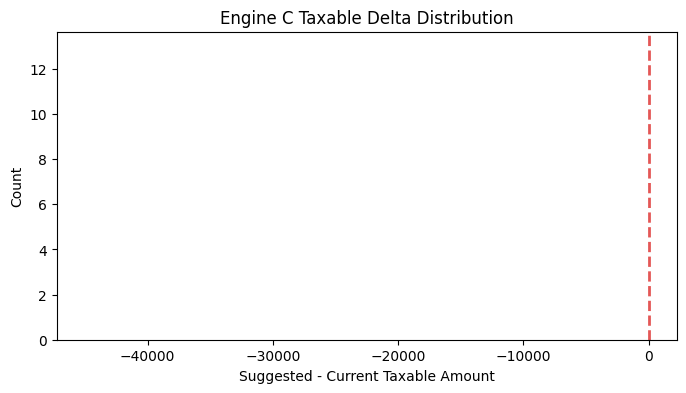

In [10]:
# Cell 10 - Plot taxable delta distribution and save

fig4, _ = plot_taxable_delta_distribution(taxable_delta)
output_path = REPORTS_FIGURES_DIR / "engine_c_taxable_delta_distribution.png"
fig4.savefig(output_path, dpi=150, bbox_inches="tight")
print("Saved:", output_path)


In [11]:
# Cell 11 - Roth tax code correction crosstab

tax_code_crosstab = build_roth_tax_code_crosstab(roth_matches)
tax_code_crosstab


suggested_tax_code,B1,B2,B4,B7,H
current_tax_code,,,,,
4,0,0,1,0,0
7,0,0,0,2,0
7B,0,0,0,1,0
B,6,2,0,7,0
B1,0,2,0,0,0
B2,2,0,0,1,0
BG,0,0,0,0,22
G,0,0,0,0,4


Saved: /Users/manuelreyes/Desktop/dev/1099_reconciliation_pipeline/reports/figures/engine_c_tax_code_crosstab.png


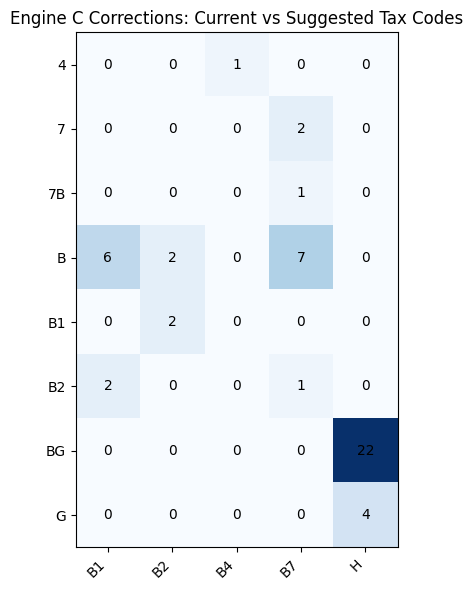

In [12]:
# Cell 12 - Plot Roth tax code crosstab and save

fig5, _ = plot_roth_tax_code_crosstab(tax_code_crosstab)
output_path = REPORTS_FIGURES_DIR / "engine_c_tax_code_crosstab.png"
fig5.savefig(output_path, dpi=150, bbox_inches="tight")
print("Saved:", output_path)


In [13]:
# Cell 13 - Correction reason trends by month

reason_trends = build_roth_correction_reason_trends(roth_matches)
reason_trends.head(10)


,txn_month,correction_reason,count
0,2025-06-01,missing_first_roth_tax_year,18
9,2025-06-01,roth_rollover_code_fix_B_G_to_H,17
1,2025-06-01,qualified_roth_distribution,10
6,2025-06-01,roth_age_tax_code_mismatch,10
10,2025-06-01,taxable_within_15pct_of_gross,10
8,2025-06-01,roth_initial_year_mismatch,8
7,2025-06-01,roth_basis_covers_2025_total,5
3,2025-06-01,roth_age_rule_attained_59_5_in_txn_year_expect_B7,4
5,2025-06-01,roth_age_rule_under_55_in_txn_year_no_term_exp...,4
2,2025-06-01,roth_age_rule_attained_55_in_txn_year_no_term_...,1


Saved: /Users/manuelreyes/Desktop/dev/1099_reconciliation_pipeline/reports/figures/engine_c_correction_reason_trends.png


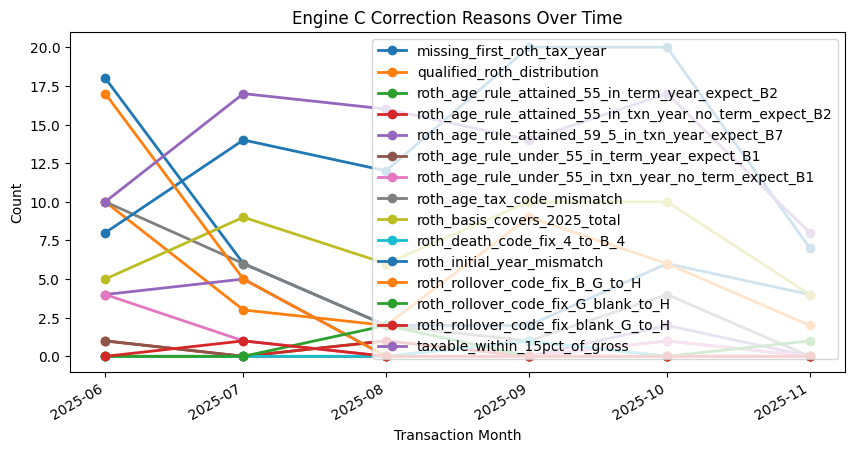

In [14]:
# Cell 14 - Plot correction reason trends and save

fig6, _ = plot_roth_correction_reason_trends(reason_trends)
output_path = REPORTS_FIGURES_DIR / "engine_c_correction_reason_trends.png"
fig6.savefig(output_path, dpi=150, bbox_inches="tight")
print("Saved:", output_path)
